In particle physics, the W and Z bosons are vector bosons that are together known as the weak bosons or more generally as the intermediate vector bosons. These elementary particles mediate the weak interaction. The Z boson is electrically neutral and is its own antiparticle. Sometimes, physicists notice that particles seem to obey a rule, but they don’t understand why. For example, Z bosons have been seen turning into an electron and a positron, or a muon and an anti-muon, but never into an electron and an anti-muon, or a muon and a positron.



For my work, I will consider two events here (**Zee** & **Zmumu**) as follows:


*   **Zee** is an event in which a Z boson turns into an electron and a positron.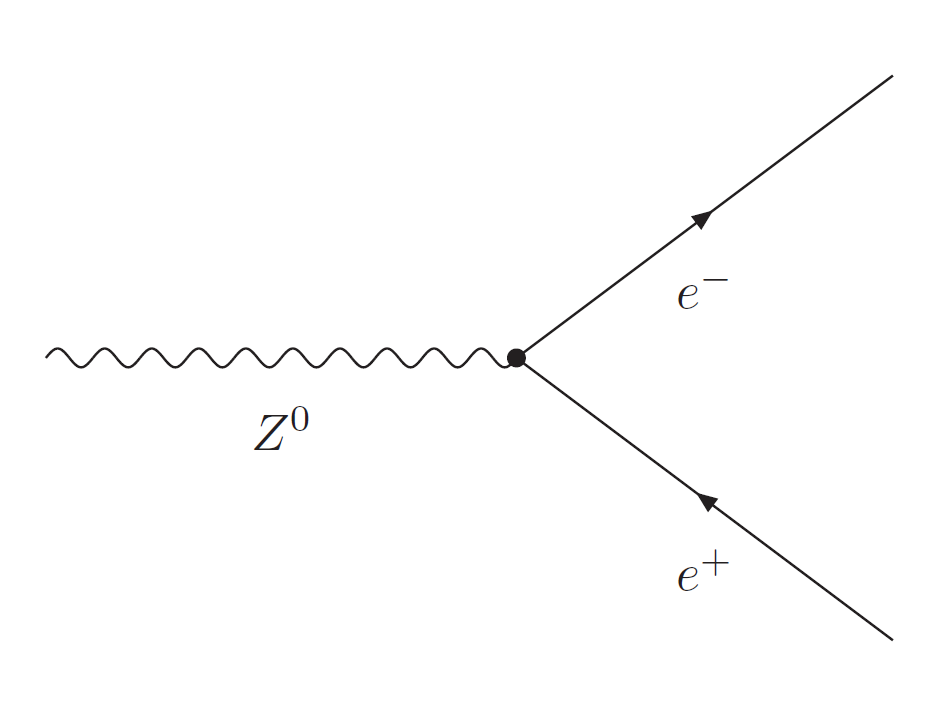

*   **Zmumu** is an event in which a Z boson turns into a muon and an anti-muon.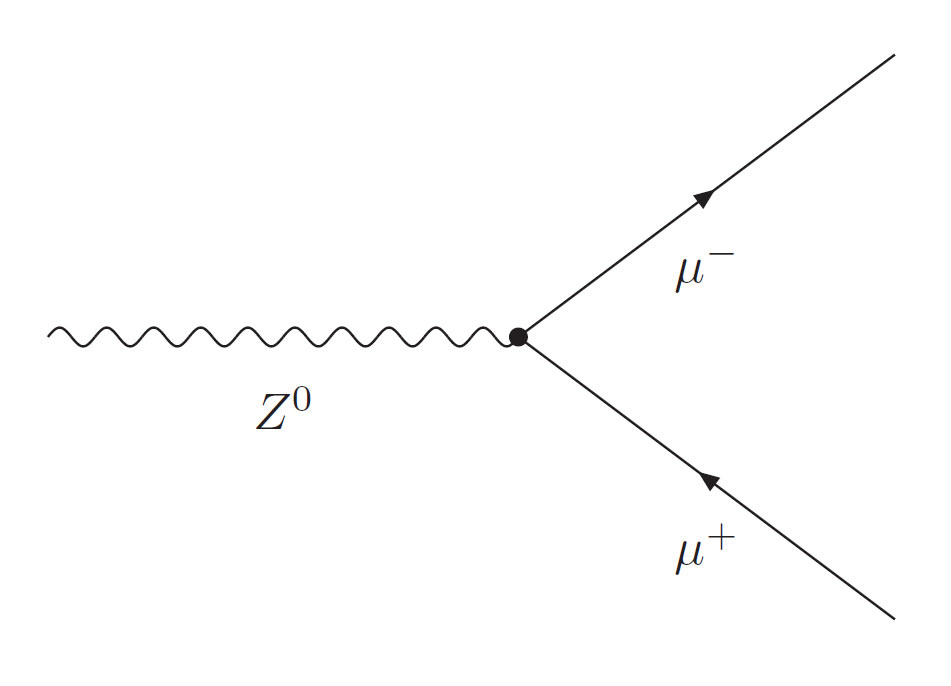



I use two datasets, which are available on the CERN Open Data portal, `Zee.csv` and `Zmumu.csv`, each of which contains 10000 records. Datasets derived from the Run2011A. These data were selected from the primary datasets in order to obtain candidate Z boson events. More details on datasets can be found in http://opendata.cern.ch/record/545.

I use TensorFlow to create a model that can distinguish between two events (**Zee** & **Zmumu**). To do this, every record in `Zee.csv` is labeled with 0 and every record in `Zmumu.csv` is labeled with 1. These two datasets are then merged.



Content:

1) Run: The run number of the event.

2) Event: The event number.

3) pt: The transverse momentum of the lepton (in units of GeV), either a muon or an electron.

4) eta: The pseudorapidity of the lepton, either a muon or an electron.

5) phi: The phi angle (in radians) of the lepton, either a muon or an electron.

6) Q: 	The charge of the lepton, either a muon or an electron.



Source: opendata.cern

In [ ]:
#Import libraries
import numpy as np
import scipy.optimize as opt
import re, seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import tensorflow as tf
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import ListedColormap
%matplotlib inline

# Read data using pandas

## The first DataFrame (Zee)

In [ ]:
# Reading data
df_Zee = pd.read_csv('/content/drive/MyDrive/Zee.csv') # datafram
# Every record in df_Zee is labeled with 0
df_Zee['class'] = 0
# Removing unwanted columns from the original dataset
df_Zee = df_Zee.drop(['type1', 'type2', 'sigmaEtaEta1', 'sigmaEtaEta2', 'HoverE1', 'HoverE2', 'isoTrack1', 'isoTrack2', 'isoEcal1',
                      'isoHcal1', 'isoEcal2', 'isoHcal2'], axis=1) 
df_Zee.head() 

,Run,Event,pt1,eta1,phi1,Q1,pt2,eta2,phi2,Q2,class
0,163286,109060857,37.5667,2.2892,2.0526,-1,45.4315,1.4706,-1.1630,1,0
1,163286,109275715,36.2901,-0.8373,-1.5859,1,60.5754,-0.4896,1.0496,-1,0
2,163286,109075352,25.9705,-0.6974,1.6360,-1,45.2954,-2.0401,3.1187,1,0
3,163286,109169766,41.0075,1.4619,-0.5325,1,45.9013,1.1561,2.4786,-1,0
4,163286,108947653,39.8985,-0.5927,-2.3947,1,34.8931,-2.2444,0.6106,-1,0


## The second DataFrame (Zmumu) 

In [ ]:
# Reading data
df_Zmumu = pd.read_csv('/content/drive/MyDrive/Zmumu.csv') # datafram
# Every record in df_Zmumu is labeled with 1
df_Zmumu['class'] = 1
# Removing unwanted columns from the original dataset
df_Zmumu = df_Zmumu.drop(['dxy1', 'dxy2', 'iso1', 'iso2'], axis=1) 
df_Zmumu.head() 

,Run,Event,pt1,eta1,phi1,Q1,pt2,eta2,phi2,Q2,class
0,165617,74969122,54.7055,-0.4324,2.5742,1,34.2464,-0.9885,-0.4987,-1,1
1,165617,75138253,24.5872,-2.0522,2.8666,-1,28.5389,0.3852,-1.9912,1,1
2,165617,75887636,31.7386,-2.2595,-1.3323,-1,30.2344,-0.4684,1.8833,1,1
3,165617,75779415,39.7394,-0.7123,-0.3123,1,48.2790,-0.1956,2.9703,-1,1
4,165617,75098104,41.2998,-0.1571,-3.0408,1,43.4508,0.5910,-0.0428,-1,1


# Combining two DataFrame with `concat()`

In [ ]:
frames = [df_Zee, df_Zmumu]  
result = pd.concat(frames)
df = result.sample(20000, random_state=42) 
df.head(5) 

,Run,Event,pt1,eta1,phi1,Q1,pt2,eta2,phi2,Q2,class
650,166784,20257329,42.9130,-1.3248,-3.0057,-1,42.2897,-0.6624,0.3485,1,1
2041,163261,64679856,39.8744,-0.0057,-0.7744,-1,36.3997,1.3710,2.2952,1,0
8668,165570,196860468,72.9296,-0.4162,0.9198,1,39.5410,-0.2680,-1.4629,1,0
1114,172163,497791581,33.4436,0.3063,-1.6034,1,27.2395,-1.6182,1.5315,-1,0
3902,173692,550966077,43.9826,0.4276,-0.3876,-1,29.7856,-0.3080,2.8965,1,1


# I need to know what type of data I am working with before I can work with DataFrame, so I check it using the `dtypes`.

In [ ]:
df.dtypes

Run        int64
Event      int64
pt1      float64
eta1     float64
phi1     float64
Q1         int64
pt2      float64
eta2     float64
phi2     float64
Q2         int64
class      int64
dtype: object

# In the DataFrame, there are 20000 records with 11 columns.

In [ ]:
df.shape

(20000, 11)

# I am going to test if there are NaN values in DataFrame

In [ ]:
df.isnull().any().any()

False

## There are no NaN values

# I use the Seaborn `heatmap()` function to determine which features have the most impact on `class`.

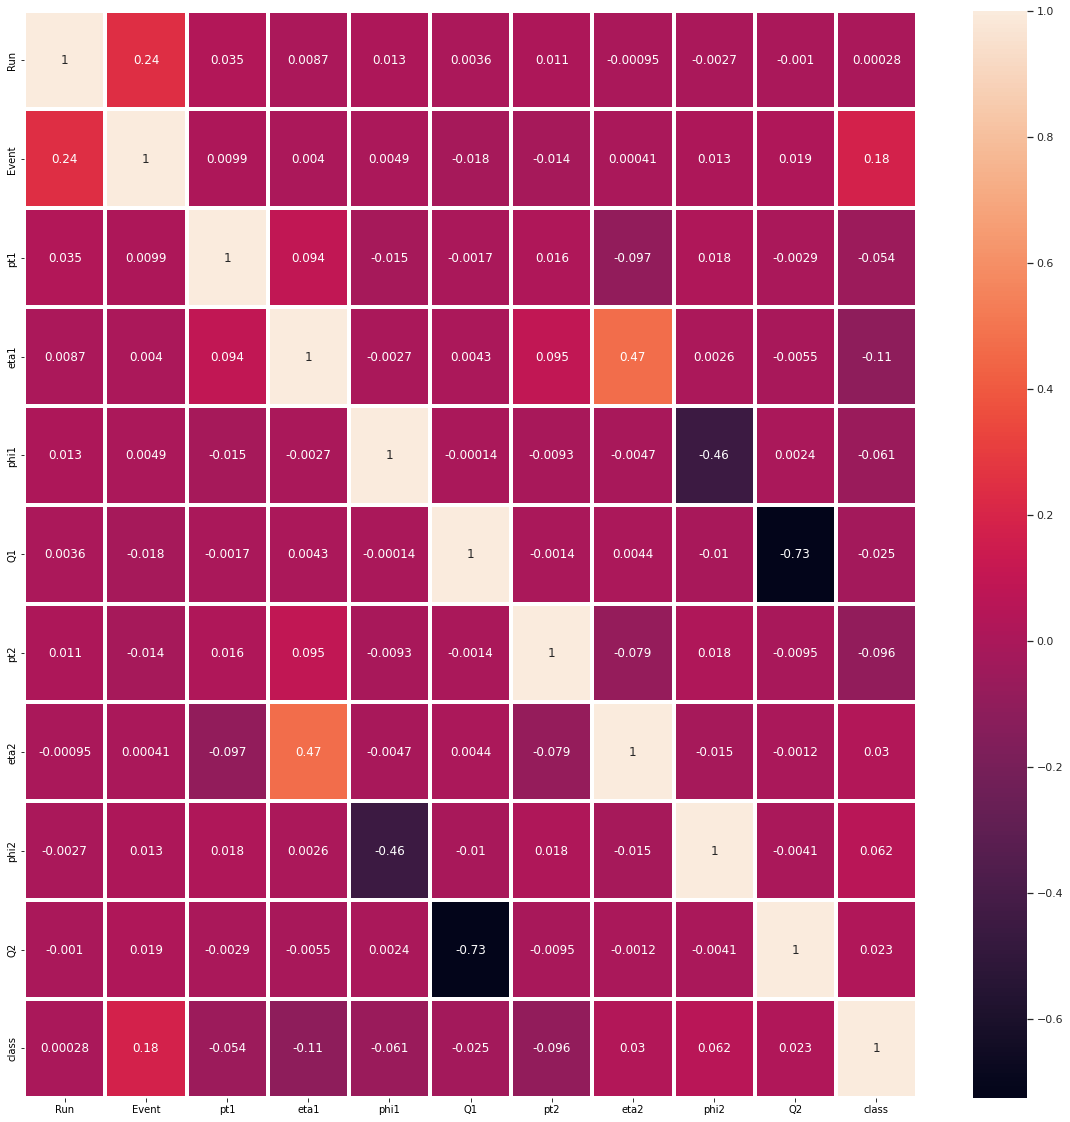

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))  
sns.set(font_scale=1.0)
sns.heatmap(df.corr() , annot= True, linewidths=3, ax=ax)

# As can be seen, the class is only affected by Event (0.18).

# The next step is to create a model to distinguish between two events (**Zee** & **Zmumu**) using TensorFlow.

## First of all, I split the DataFrame into X (data) and Y (label), where:

In [ ]:
X = df.drop(['class'], axis=1)
y = df['class']  

## Using a train-test split, I split X and Y into train and test data.


*   Train Dataset: Used to fit model.
*   Test Dataset: Used to evaluate the fit model.



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

## TensorFlow
The first thing I do is train a simple Neural Network using TensorFlow, and then plot accuracy and loss graphs on the training and validation datasets to find a balance between the model that is underfitting and one that is overfitting, resulting in a model with a good fit. I first need to convert the train and test data into a TensorFlow tensor.

## To convert DataFrame to a tensor, I use tf.convert_to_tensor

In [ ]:
tf.convert_to_tensor(X_train)

<tf.Tensor: shape=(16000, 10), dtype=float64, numpy=
array([[ 1.65548000e+05,  6.48707483e+08,  5.05841000e+01, ...,
         7.57700000e-01, -1.15100000e-01,  1.00000000e+00],
       [ 1.66438000e+05,  3.02651184e+08,  4.09797000e+01, ...,
        -1.47620000e+00, -2.11380000e+00,  1.00000000e+00],
       [ 1.66895000e+05,  9.42911570e+07,  1.34816000e+01, ...,
         1.28570000e+00, -2.77300000e-01, -1.00000000e+00],
       ...,
       [ 1.66841000e+05,  8.55049598e+08,  5.25216000e+01, ...,
         2.89900000e-01,  1.91300000e-01,  1.00000000e+00],
       [ 1.67807000e+05,  1.12731745e+09,  4.15585000e+01, ...,
        -7.40700000e-01, -3.85000000e-01,  1.00000000e+00],
       [ 1.70759000e+05,  3.91745013e+08,  3.10681000e+01, ...,
        -2.47390000e+00,  2.63060000e+00,  1.00000000e+00]])>

In [ ]:
tf.convert_to_tensor(X_test)

<tf.Tensor: shape=(4000, 10), dtype=float64, numpy=
array([[ 1.67830000e+05,  2.30720986e+08,  3.70204000e+01, ...,
        -1.82500000e+00,  1.98250000e+00, -1.00000000e+00],
       [ 1.63237000e+05,  1.00349630e+07,  2.76417000e+01, ...,
         9.28800000e-01,  1.67100000e-01,  1.00000000e+00],
       [ 1.73406000e+05,  2.28414501e+08,  3.07497000e+01, ...,
         2.14560000e+00,  2.88740000e+00,  1.00000000e+00],
       ...,
       [ 1.65617000e+05,  1.09972750e+08,  5.49275000e+01, ...,
         7.10200000e-01, -3.64400000e-01,  1.00000000e+00],
       [ 1.72163000e+05,  5.01236827e+08,  2.85396000e+01, ...,
         1.20530000e+00,  1.12420000e+00,  1.00000000e+00],
       [ 1.67098000e+05,  1.95070668e+08,  2.57243000e+01, ...,
         4.85500000e-01, -1.53040000e+00, -1.00000000e+00]])>

## Normalize X_train, X_test

In [ ]:
X_train_scaled = tf.keras.layers.Normalization(axis=-1)
X_train_scaled.adapt(X_train)

In [ ]:
X_test_scaled = tf.keras.layers.Normalization(axis=-1)
X_test_scaled.adapt(X_test)

## Building a simple neural network model
The compile function takes three arguments: optimizer, loss, and metrics.


*   **Optimizer**: These are certain algorithms that are used to change the attributes of the neural network to decrease the loss rate.
*   **Loss**: This is used to compute the quantity that a model should seek to minimize during training.


*   Metrics: This is used to judge the performance of the model.





## Model: There are two hidden layers, each with `64 neurons` and an activation function of `sigmoid`, `epochs = 1000`, and `batch_size = 100`

In [ ]:
def get_basic_model():
  model = tf.keras.Sequential([
    X_train_scaled,
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax) 
  ])

  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model
model = get_basic_model()
history = model.fit(X_train, y_train, epochs=1000, validation_data=(X_test, y_test), batch_size=100)

Epoch 1/1000
160/160 [==============================] - 1s 4ms/step - loss: 0.6816 - accuracy: 0.5527 - val_loss: 0.6666 - val_accuracy: 0.5700
Epoch 2/1000
160/160 [==============================] - 0s 3ms/step - loss: 0.6606 - accuracy: 0.5899 - val_loss: 0.6602 - val_accuracy: 0.5835
Epoch 3/1000
160/160 [==============================] - 0s 3ms/step - loss: 0.6606 - accuracy: 0.5848 - val_loss: 0.6594 - val_accuracy: 0.5950
Epoch 4/1000
160/160 [==============================] - 0s 3ms/step - loss: 0.6587 - accuracy: 0.5899 - val_loss: 0.6586 - val_accuracy: 0.5950
Epoch 5/1000
160/160 [==============================] - 0s 3ms/step - loss: 0.6581 - accuracy: 0.5901 - val_loss: 0.6588 - val_accuracy: 0.5792
Epoch 6/1000
160/160 [==============================] - 0s 3ms/step - loss: 0.6569 - accuracy: 0.5888 - val_loss: 0.6676 - val_accuracy: 0.5590
Epoch 7/1000
160/160 [==============================] - 0s 3ms/step - loss: 0.6541 - accuracy: 0.5951 - val_loss: 0.6539 - val_accuracy:

## Evaluating the model
I create plots from the collected history data.


*   A plot of accuracy on the training and validation datasets over training epochs.
*   A plot of loss on the training and validation datasets over training epochs.



125/125 - 0s - loss: 0.2484 - accuracy: 0.9000 - 288ms/epoch - 2ms/step


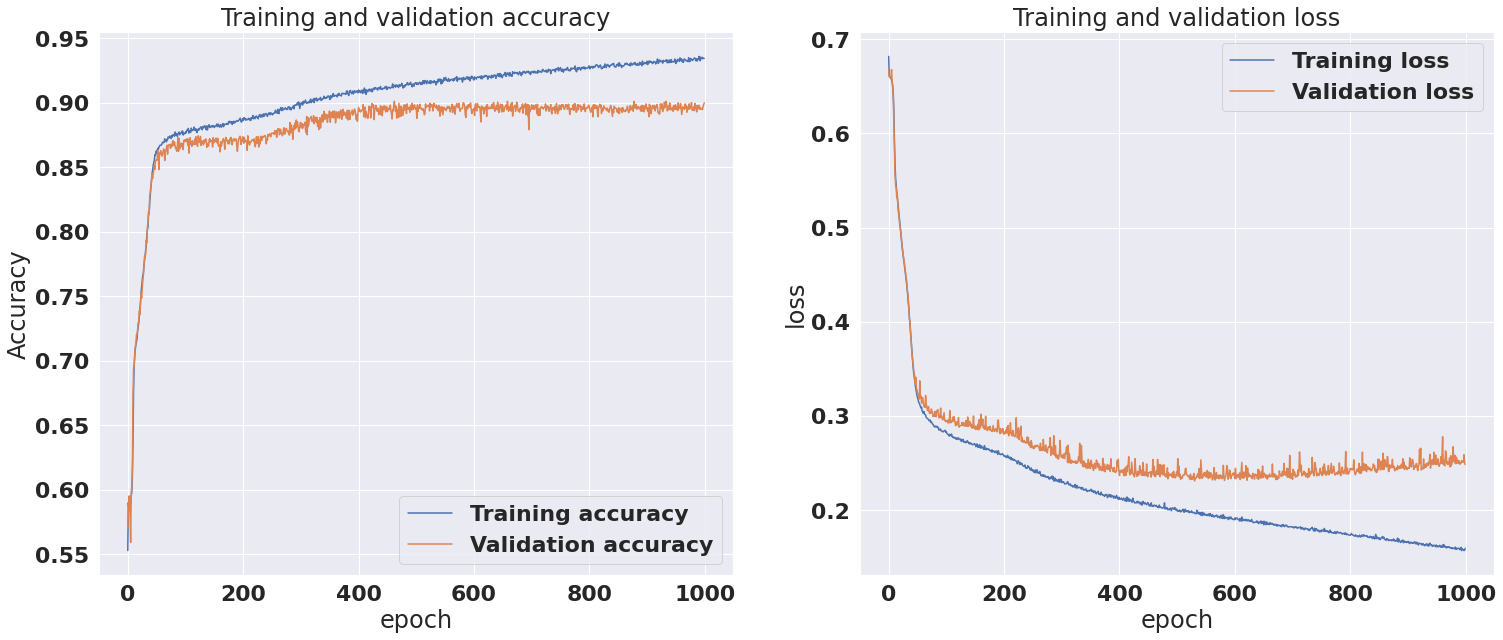

In [ ]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)

plt.figure(figsize=(25,10))

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1.plot(history.history['accuracy'], label='Training accuracy')
ax1.plot(history.history['val_accuracy'], label = 'Validation accuracy') 
ax1.set_title("Training and validation accuracy")
ax1.set(xlabel='epoch', ylabel='Accuracy')
ax1.legend(loc='lower right')

ax2.plot(history.history['loss'], label='Training loss')
ax2.plot(history.history['val_loss'], label='Validation loss')
ax2.set_title("Training and validation loss")
ax2.set(xlabel='epoch', ylabel='loss')
ax2.legend(loc='upper right')
#To check the network accuracy on test data
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

According to the plot of loss, validation loss is decreasing before the 600th epoch, so the model is underfitting. However, after the 600th epoch, Validation loss is increasing, indicating an overfitted model. At the 600th epoch, when the model is either perfectly fitted or in a local minimum, the neural network model achieved an accuracy of 90%. The goal of Deep Learning training is to find a balance between a model that is underfitting and one that is overfitting(converging), resulting in a model with a good fit. I found an optimum where the change in the slope of loss is around the 600th epoch, as shown above. At that point, the training process can be stopped.